In [89]:
import sys
sys.path.append(r'../script/')
from protein_composition import *
import pandas as pd
import re
import os
import numpy as np

In [90]:
# strain='BW25113_pro'
# strain='BW25113'
# strain='DH1'
# strain='MG1655'
strain='W3110'
# strain='Bacillus'
# strain='Yeast_single_cell'
# strain='Corynebacterium_RNA_seq'

# Data description

## E.coli
### Literature: Multi-omics integration accurately predicts cellular state in unexplored conditions for Escherichia coli
### Type: Absolute-level quantification

## Yeast_single_cell
### https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE122392
### Literature: Sensitive, high-throughput single-cell RNA-Seq reveals within-clonal transcript-correlations in yeast populations
### Type: Single-cell RNA-Seq

## Pseudomonas
### collected the data from the ArrayExpress database and used the rma function in Bioconductor’s affy R package for background correction and quantile normalization.
### Literature: ADAGE-Based Integration of Publicly Available Pseudomonas aeruginosa Gene Expression Data with Denoising Autoencoders Illuminates Microbe-Host Interactions
### Type: Microarray

## Bacillus
### microarray data and used Bioconductor’s limma R package for quantile normalization.
### Literature: Condition-Dependent Transcriptome Reveals High-Level Regulatory Architecture in Bacillus subtilis
### Type: Microarray

## Corynebacterium glutamicum
### RNA_seq data using Nextflow workflow
### Type: RNA-Seq

In [91]:
if re.search('_pro',strain):
    proteome_file='../basic_data/omics_data/%s_proteome.csv'%strain
elif re.search('_single_cell',strain):
    proteome_file='../basic_data/omics_data/%s_transcriptome.csv'%strain
elif re.search('_RNA_seq',strain):
    proteome_file='../basic_data/omics_data/%s_transcriptome.csv'%strain
else:
    proteome_file='../basic_data/omics_data/%s_trans_transcriptome.csv'%strain

In [92]:
result_file='../analysis_result/initial_data/%s/'%strain
if not os.path.exists(result_file):
    os.makedirs(result_file)

# Get protein MW/Sequence corresponding to gene id using uniprot API   
https://www.uniprot.org/help/uniprotkb_column_names   
https://www.uniprot.org/help/api_idmapping   

In [93]:
gene_uniprot_outfile='../download_data/Gene_name2ACC_MW_%s.txt'%strain
my_pro_exp=pd.read_csv(proteome_file,index_col=0) 
print(my_pro_exp.shape) 

if re.search('Pseudomonas',strain):
    GENEID_2_ACC_from_uniprot(my_pro_exp.index,gene_uniprot_outfile)
else:
    GENENAME_2_ACC_from_uniprot(my_pro_exp.index,gene_uniprot_outfile)

(4096, 280)


对uniprot数据筛选

In [94]:
gene_uniprot_select_outfile= result_file + 'Gene_name2ACC_MW_%s_select.txt'%strain

P_ACC_SEQ2ACC_MW_select=gene_uniprot_select(gene_uniprot_outfile,gene_uniprot_select_outfile)
P_ACC_SEQ2ACC_MW_select.head(5)

Total gene in uniprot: 5361
Total selected gene in uniprot: 4088


,Entry name,Protein names,Gene names,Organism,EC number,Mass,Sequence,Gene ontology IDs,Cross-reference (KEGG),Gene ID
Entry,,,,,,,,,,
P0ACG4,HOKC_ECOLI,Toxic protein HokC (Protein Gef),hokC gef b4412 JW5002 b0018.1,Escherichia coli (strain K12),NaN,"5,502",MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVFTA...,GO:0005886; GO:0042597,ecj:JW5002;eco:b4412;,b4412
P0CE53,INSH6_ECOLI,Transposase InsH for insertion sequence elemen...,insH6 b1994 JW1972,Escherichia coli (strain K12),NaN,"37,823",MSHQLTFADSEFSSKRRQTRKEIFLSRMEQILPWQNMVEVIEPFYP...,GO:0003677; GO:0004803; GO:0006313,ecj:JW1972;eco:b1994;,b1994
P0CF43,INSC4_ECOLI,Transposase InsC for insertion element IS2H,insC4 b2861 JW2829,Escherichia coli (strain K12),NaN,"13,452",MIDVLGPEKRRRRTTQEKIAIVQQSFEPGMTVSLVARQHGVAASQL...,GO:0003677; GO:0004803; GO:0006313,ecj:JW2829;eco:b0360;eco:b1403;eco:b1997;eco:b...,b2861
P77494,HOKB_ECOLI,Toxic protein HokB,hokB ydcB b4428 JW5225,Escherichia coli (strain K12),NaN,"5,626",MKHNPLVVCLLIICITILTFTLLTRQTLYELRFRDGDKEVAALMACTSR,GO:0005886; GO:0022611,ecj:JW5225;eco:b4428;,b4428
P0CF26,INSB2_ECOLI,Insertion element IS1 2 protein InsB (IS1b),insB2 b0264 JW0256,Escherichia coli (strain K12),NaN,"19,758",MPGNRPHYGRWPQHDFPPFKKLRPQSVTSRIQPGSDVIVCAEMDEQ...,GO:0003677; GO:0004803; GO:0006313,ecj:JW0256;eco:b0264;eco:b0274;,b0264


## Get amino acid composiotion from protein sequence
从蛋白序列得到氨基酸组成

相对分子质量的单位是“1” ，而摩尔质量的单位是g/mol；

In [95]:
gene_uniprot_select_outfile=result_file + 'Gene_name2ACC_MW_%s_select.txt'%strain
amino_acid_information_file='../basic_data/amino_acid_information.csv'
seq_amino_composition_file=result_file + 'seq_amino_composition_%s.csv'%strain
seq_amino_composition_MW_file=result_file + 'seq_amino_composition_g_g_%s.csv'%strain

[seq_amino_composition,seq_amino_composition_MW]=protein_amino_composition(gene_uniprot_select_outfile,amino_acid_information_file,seq_amino_composition_file,seq_amino_composition_MW_file)
seq_amino_composition_MW.head(5)

,Gly,Ala,Val,Leu,Ile,Phe,Trp,Tyr,Asp,Asn,Glu,Lys,Gln,Met,Ser,Thr,Cys,Pro,His,Arg
b4412,0.013644,0.113346,0.170338,0.071521,0.119202,0.030024,0.000000,0.032932,0.024191,0.000000,0.106965,0.079711,0.053126,0.054238,0.019100,0.108252,0.044042,0.000000,0.056401,0.063322
b1994,0.031756,0.065952,0.037168,0.110976,0.058956,0.061144,0.032398,0.033533,0.049266,0.052397,0.089469,0.077302,0.085009,0.059174,0.044455,0.053540,0.003203,0.036527,0.057432,0.115142
b2861,0.050225,0.099342,0.078379,0.126763,0.048755,0.024560,0.030364,0.026939,0.019789,0.009822,0.131249,0.108675,0.108646,0.044368,0.039061,0.044276,0.000000,0.042793,0.023069,0.103598
b4428,0.013343,0.047506,0.062469,0.209835,0.093260,0.058724,0.000000,0.032206,0.047316,0.023484,0.052304,0.051969,0.025978,0.053043,0.018679,0.127039,0.064607,0.020464,0.027579,0.123854
b0264,0.041794,0.027054,0.071151,0.106221,0.046472,0.050164,0.051683,0.073364,0.047156,0.026748,0.044680,0.081389,0.066573,0.037759,0.063826,0.036174,0.006132,0.052443,0.070677,0.149884


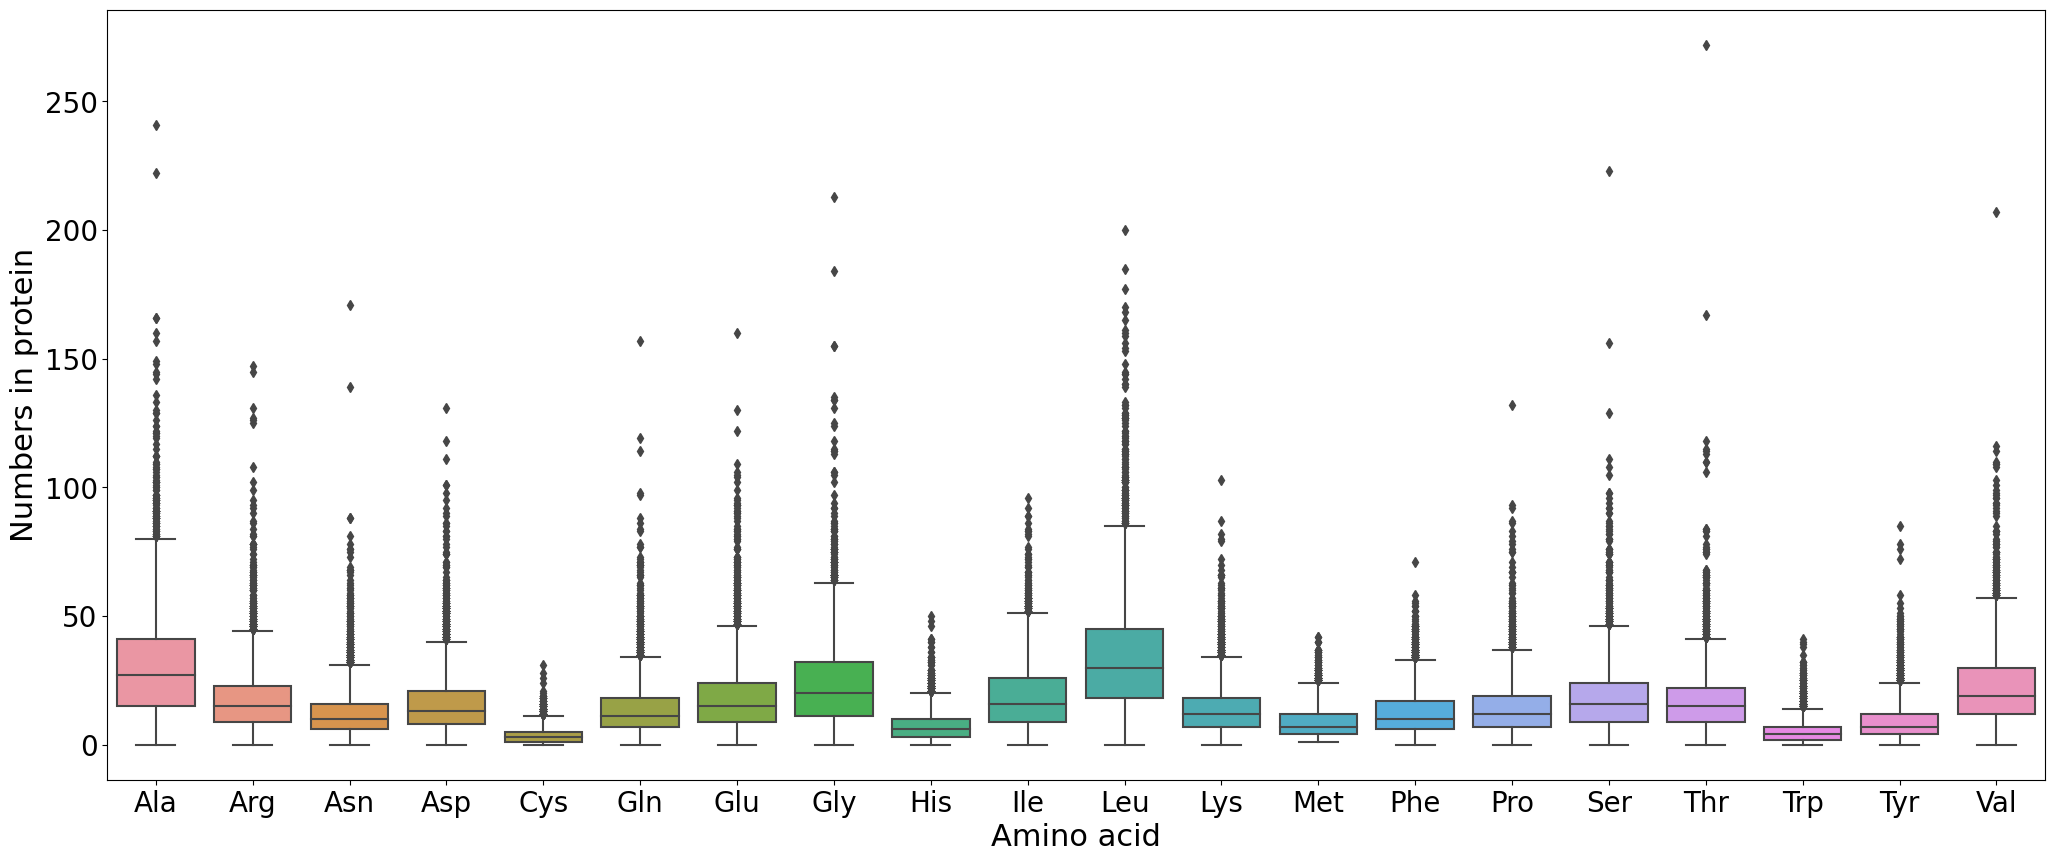

In [96]:
seq_amino_composition_file=result_file + 'seq_amino_composition_%s.csv'%strain
pngname=result_file + 'protein_amino_acid_composition_boxplot_%s.png'%strain
draw_amino_numbers(seq_amino_composition_file,pngname)

# Amino acid composition condsider protein sequence (normalized 1g protein)

In [97]:
seq_amino_composition_MW_file=result_file + 'seq_amino_composition_g_g_%s.csv'%strain
seq_amino_composition_MW_norm_file=result_file + 'seq_amino_composition_g_g_norm_%s.csv'%strain

seq_amino_composition_g_g_norm=amino_mass_norm(seq_amino_composition_MW_file,seq_amino_composition_MW_norm_file)
seq_amino_composition_g_g_norm.head(5)

/home/zhang_y/Project/aacomics/notebook/../script/protein_composition.py:119: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  seq_amino_composition_g_g_norm=seq_amino_composition_g_g/seq_amino_composition_g_g.sum(axis=1)[:,None]


,Gly,Ala,Val,Leu,Ile,Phe,Trp,Tyr,Asp,Asn,Glu,Lys,Gln,Met,Ser,Thr,Cys,Pro,His,Arg
b4412,0.011759,0.097682,0.146798,0.061637,0.102729,0.025874,0.000000,0.028381,0.020848,0.000000,0.092183,0.068695,0.045784,0.046743,0.016461,0.093292,0.037956,0.000000,0.048607,0.054572
b1994,0.027499,0.057112,0.032186,0.096100,0.051053,0.052948,0.028055,0.029038,0.042662,0.045373,0.077476,0.066940,0.073614,0.051242,0.038496,0.046363,0.002774,0.031631,0.049733,0.099707
b2861,0.043273,0.085590,0.067529,0.109215,0.042006,0.021160,0.026161,0.023210,0.017050,0.008462,0.113080,0.093631,0.093606,0.038226,0.033654,0.038147,0.000000,0.036869,0.019875,0.089257
b4428,0.011566,0.041179,0.054149,0.181886,0.080838,0.050902,0.000000,0.027916,0.041014,0.020356,0.045337,0.045048,0.022518,0.045978,0.016191,0.110118,0.056002,0.017738,0.023906,0.107357
b0264,0.036300,0.023498,0.061798,0.092259,0.040363,0.043570,0.044889,0.063720,0.040957,0.023232,0.038807,0.070691,0.057822,0.032796,0.055436,0.031419,0.005326,0.045549,0.061387,0.130181


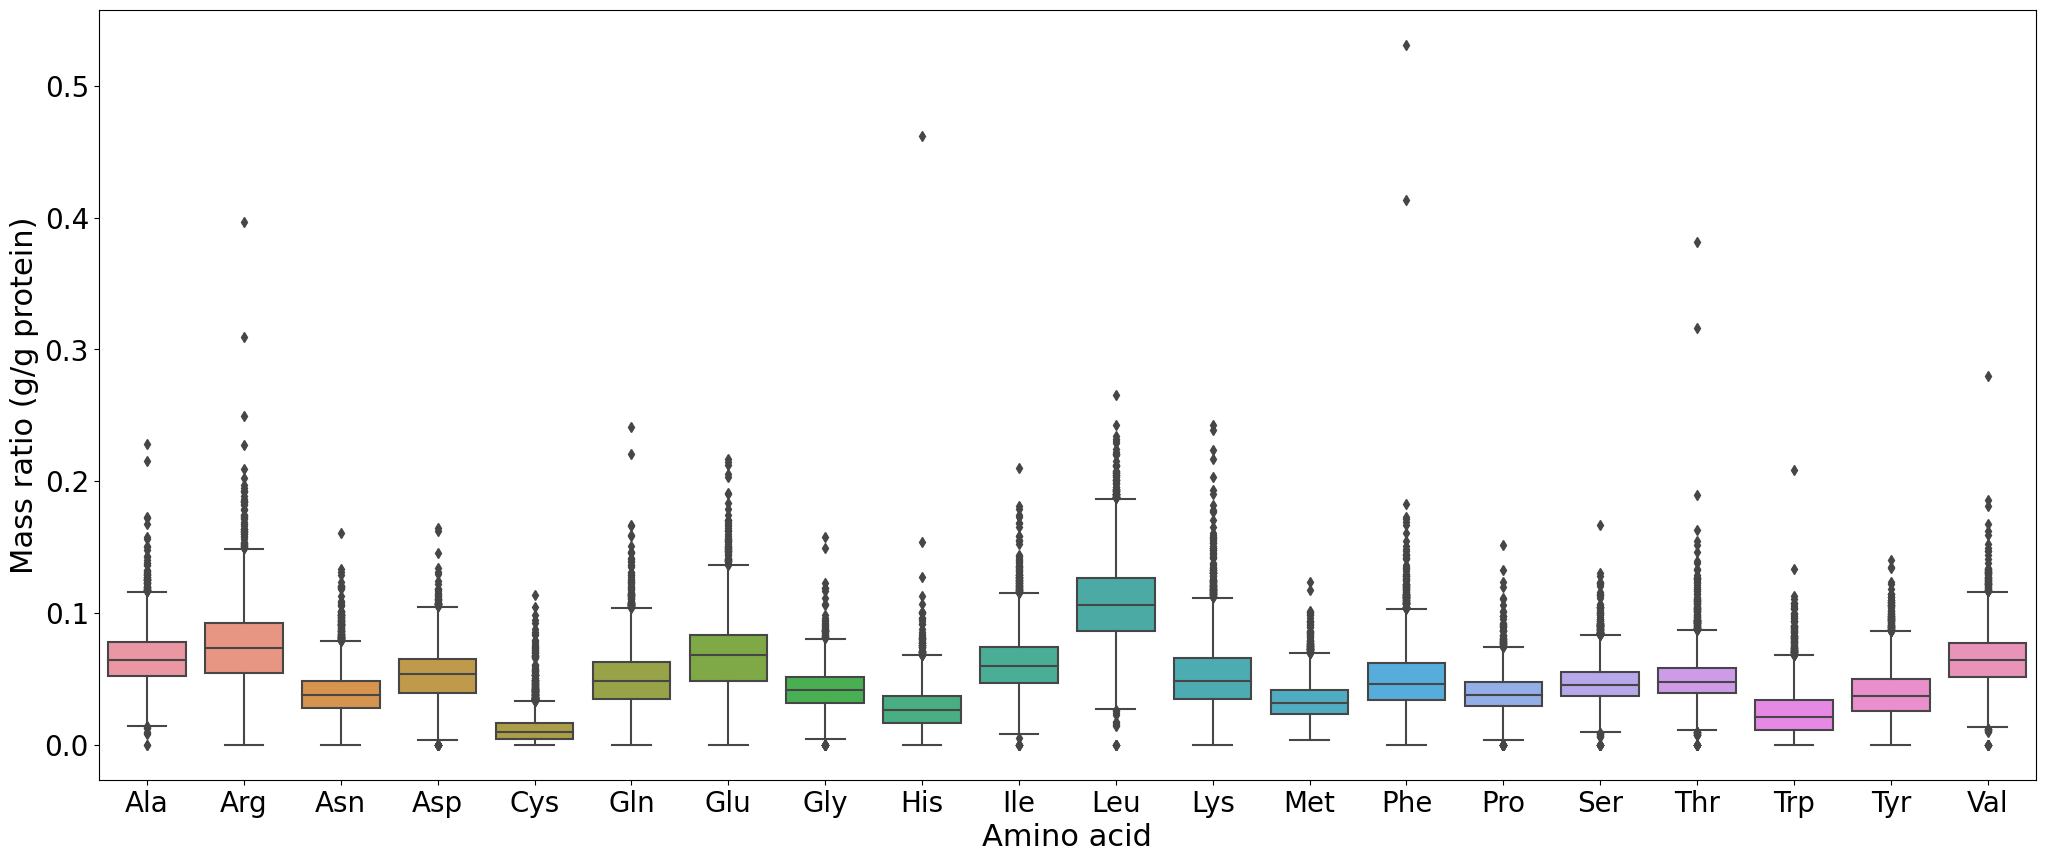

In [98]:
seq_amino_composition_MW_norm_file=result_file + 'seq_amino_composition_g_g_norm_%s.csv'%strain
pngname=result_file + 'protein_amino_acid_composition_g_g_boxplot_%s.png'%strain

draw_amino_mass(seq_amino_composition_MW_norm_file,pngname)

# Amino acids composition of each protein (g / g protein) consider expression level under different conditions

In [99]:
gene_uniprot_select_outfile=result_file + 'Gene_name2ACC_MW_%s_select.txt'%strain

my_pro_exp=pd.read_csv(proteome_file,index_col=0) 
P_ACC_SEQ2ACC_MW=pd.read_csv(gene_uniprot_select_outfile,index_col='Gene ID')
my_pro_exp.head(5)

,W3110.MD001.Indole.hns(delete)93-1_VAR_T1315,W3110.MD016.none.na_WT_T0187,W3110.MD018.none.na_WT_T0197,W3110.MD018.none.na_WT_T0198,W3110.MD018.none.na_WT_T0212,W3110.MD018.none.na_WT_T1505,W3110.MD018.none.na_WT_T1507,W3110.MD018.dna-damage.na_WT_T1509,W3110.MD018.dna-damage.na_WT_T1513,W3110.MD018.dna-damage.na_WT_T1515,...,W3110.MD018.none.na_WT_T7056,W3110.MD018.none.na_WT_T7058,W3110.MD018.none.na_WT_T7060,W3110.MD018.none.na_WT_T7062,W3110.MD018.none.na_WT_T7078,W3110.MD018.none.na_WT_T7080,W3110.MD018.none.na_WT_T7082,W3110.MD018.none.na_WT_T7084,W3110.MD125.none.b0345_KO_T7975,W3110.MD125.none.b0002_OE;b0003_OE;b0004_OE_T7976
b4412,0.067421,0.117882,0.085563,0.085563,0.085563,0.085563,0.085563,0.085563,0.085563,0.085563,...,0.064320,0.062058,0.055847,0.055028,0.055121,0.056497,0.061867,0.055144,0.164280,0.092792
b1994,0.130231,0.130231,0.130231,0.130231,0.130231,0.163811,0.017788,0.146941,0.087880,0.169484,...,0.069916,0.071408,0.061723,0.059184,0.060077,0.061619,0.070346,0.062863,0.158736,0.149237
b2861,0.198816,0.198816,0.198816,0.198816,0.198816,0.050296,0.039146,0.072394,0.074430,0.037178,...,0.059434,0.057503,0.053585,0.053484,0.052508,0.054873,0.058313,0.051844,0.272834,0.410315
b4428,0.052340,0.028481,0.087420,0.087420,0.087420,0.087420,0.087420,0.087420,0.087420,0.087420,...,0.068909,0.068957,0.060462,0.057971,0.058365,0.060149,0.068325,0.061085,0.166328,0.136509
b0264,0.115444,0.115444,0.115444,0.115444,0.115444,0.164788,0.168613,0.185232,0.136974,0.170729,...,0.068701,0.068391,0.059379,0.057776,0.058184,0.059888,0.067606,0.060503,0.084852,0.087867


In [100]:
gene_uniprot_select_outfile=result_file + 'Gene_name2ACC_MW_%s_select.txt'%strain
protein_expression_mass_norm_outfile=result_file + '%s_exp_onecell.json'%strain

protein_expression_mass_norm_json=protein_expression_mass_norm(proteome_file,gene_uniprot_select_outfile,protein_expression_mass_norm_outfile)

/home/zhang_y/anaconda3/envs/AAComics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0.222624725


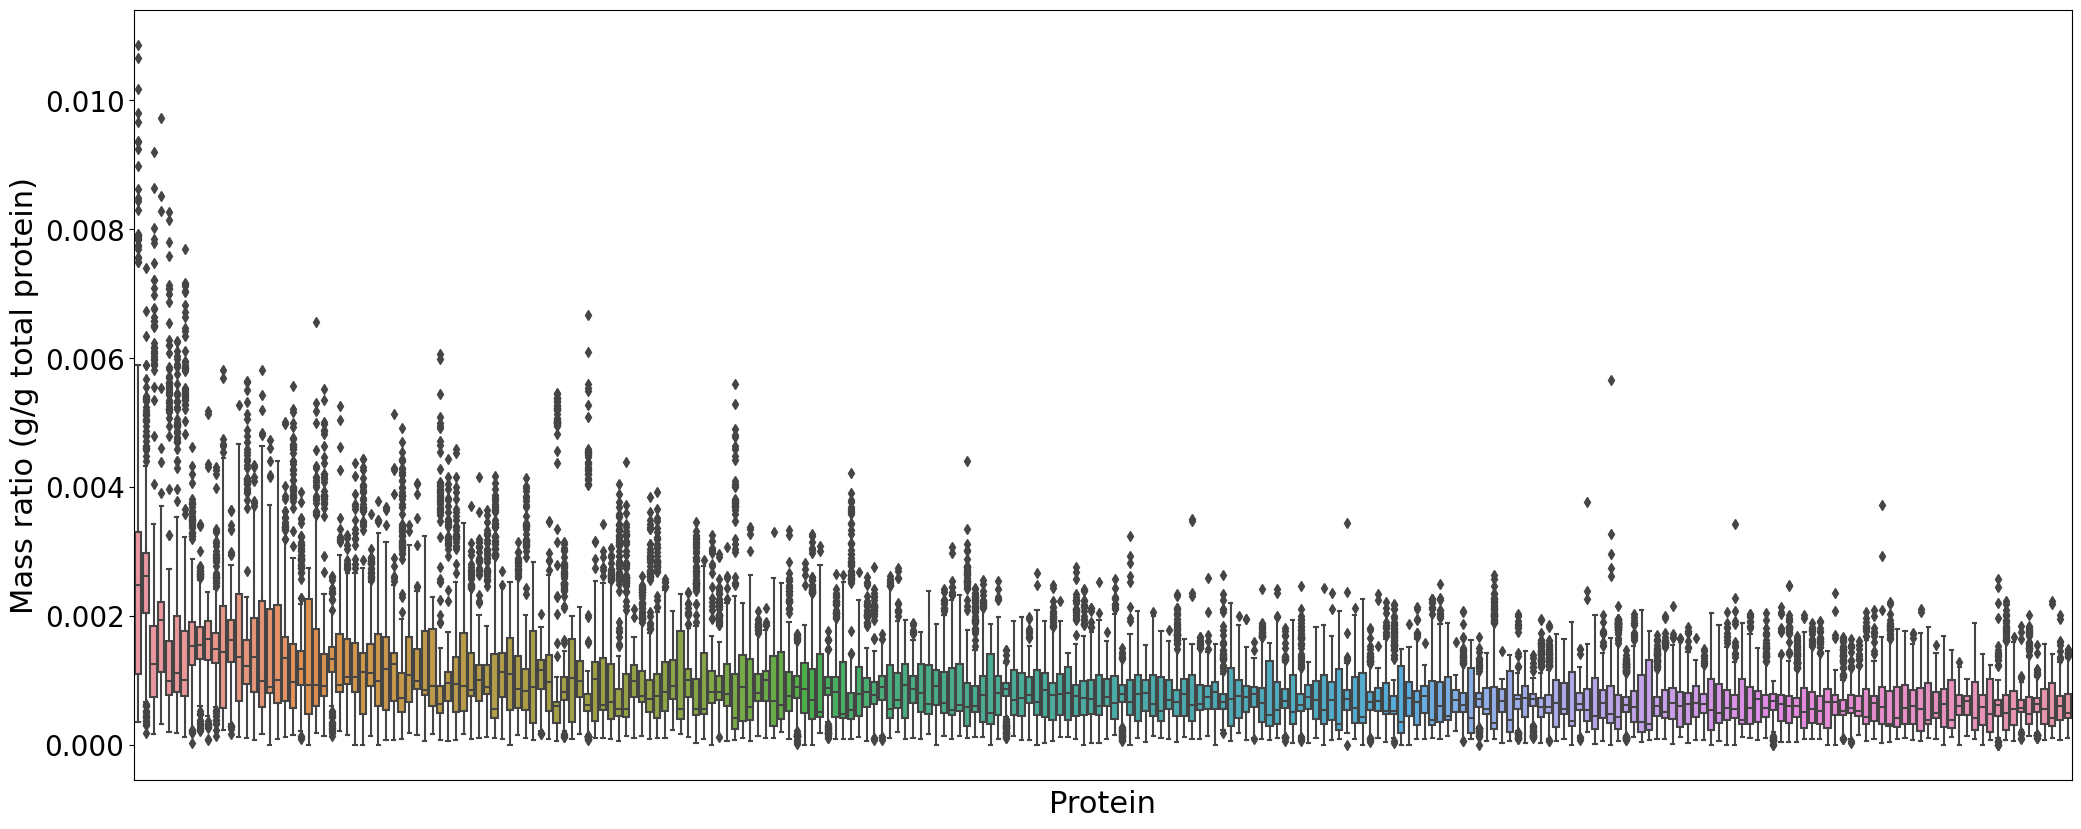

In [101]:
protein_expression_mass_norm_outfile=result_file + '%s_exp_onecell.json'%strain
protein_expression_mass_norm_data=json_load(protein_expression_mass_norm_outfile) 
protein_expression_mass_norm_df=pd.DataFrame(protein_expression_mass_norm_data).T

#delete outliers
if re.search('_pro',strain):
    #condition: b3916(KO) 
    protein_expression_mass_norm_df=protein_expression_mass_norm_df.drop(['b3916(KO)'])
elif re.search('DH1',strain):
    #condition: DH1.MD018.FPP.mevalonate-pw_IN_T5223#DH1.MD018.none.mevalonate-pw_IN;FPP-pw_IN_T5222#DH1.MD018.FPP.mevalonate-pw_IN_T5215;
    protein_expression_mass_norm_df=protein_expression_mass_norm_df.drop(['DH1.MD018.FPP.mevalonate-pw_IN_T5223','DH1.MD018.none.mevalonate-pw_IN;FPP-pw_IN_T5222','DH1.MD018.FPP.mevalonate-pw_IN_T5215'])    
elif re.search('MG1655',strain):
    #condition: MG1655.MD097.O2-starvation;CORM-3.na_WT_T6149#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6128#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6145#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6126#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6153#MG1655.MD018.Cfs;Mcn.na_WT_T0040#MG1655.MD097.O2-starvation.na_WT_T6125#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6155#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6151#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6171#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6130#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6132#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6134#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6136#MG1655.MD018.Mcn.na_WT_T0029#MG1655.MD097.O2-starvation.na_WT_T6214#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6167#MG1655.MD010.lactate-shift.na_WT_T0840#MG1655.MD003.none.na_WT_T1588#MG1655.MD003.none.na_WT_T1590#MG1655.MD003.none.na_WT_T1593#MG1655.MD097.O2-starvation.na_WT_T6184#MG1655.MD097.O2-starvation.na_WT_T6216#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6165#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6169#MG1655.MD097.O2-starvation;CORM-3.na_WT_T6143#MG1655.MD090.none.na_WT_T8309#MG1655.MD010.lactate-shift.na_WT_T0841#MG1655.MD091.none.na_WT_T8318#MG1655.MD116.none.na_WT_T1713#MG1655.MD027.none.na_WT_T1941#MG1655.MD027.none.na_WT_T1942#MG1655.MD027.none.na_WT_T1943#MG1655.MD097.O2-starvation.na_WT_T6178
    protein_expression_mass_norm_df=protein_expression_mass_norm_df.drop(['MG1655.MD097.O2-starvation;CORM-3.na_WT_T6149','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6128','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6145','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6126','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6153','MG1655.MD018.Cfs;Mcn.na_WT_T0040','MG1655.MD097.O2-starvation.na_WT_T6125','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6155','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6151','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6171','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6130','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6132','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6134','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6136','MG1655.MD018.Mcn.na_WT_T0029','MG1655.MD097.O2-starvation.na_WT_T6214','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6167','MG1655.MD010.lactate-shift.na_WT_T0840','MG1655.MD003.none.na_WT_T1588','MG1655.MD003.none.na_WT_T1590','MG1655.MD003.none.na_WT_T1593','MG1655.MD097.O2-starvation.na_WT_T6184','MG1655.MD097.O2-starvation.na_WT_T6216','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6165','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6169','MG1655.MD097.O2-starvation;CORM-3.na_WT_T6143','MG1655.MD090.none.na_WT_T8309','MG1655.MD010.lactate-shift.na_WT_T0841','MG1655.MD091.none.na_WT_T8318','MG1655.MD116.none.na_WT_T1713','MG1655.MD027.none.na_WT_T1941','MG1655.MD027.none.na_WT_T1942','MG1655.MD027.none.na_WT_T1943','MG1655.MD097.O2-starvation.na_WT_T6178'])    
elif re.search('BW25113',strain):
    #condition: BW25113.MD106.none.na_WT_T5490 
    protein_expression_mass_norm_df=protein_expression_mass_norm_df.drop(['BW25113.MD106.none.na_WT_T5490'])        

topnum=250
top_filename=result_file + ''+strain+'_'+str(topnum)+'_expdata.csv'
pngname=result_file + 'protein_top%s_exp%s.png'%(topnum,strain)
use_prot=top_protein_mass_ratio(protein_expression_mass_norm_df,topnum,top_filename,pngname)

# Amino acids composition of each condaition (g / g total protein) consider expression level

In [102]:
seq_amino_composition_MW_norm_file=result_file + 'seq_amino_composition_g_g_norm_%s.csv'%strain
protein_expression_mass_norm_outfile=result_file + '%s_exp_onecell.json'%strain
amino_composition_norm_onecell_outfile=result_file + 'amino_composition_g_g_norm_onecell_%s.json'%strain
amino_acid_expression_mass_norm_json=amino_acid_expression_mass_norm(protein_expression_mass_norm_outfile,seq_amino_composition_MW_norm_file,amino_composition_norm_onecell_outfile)

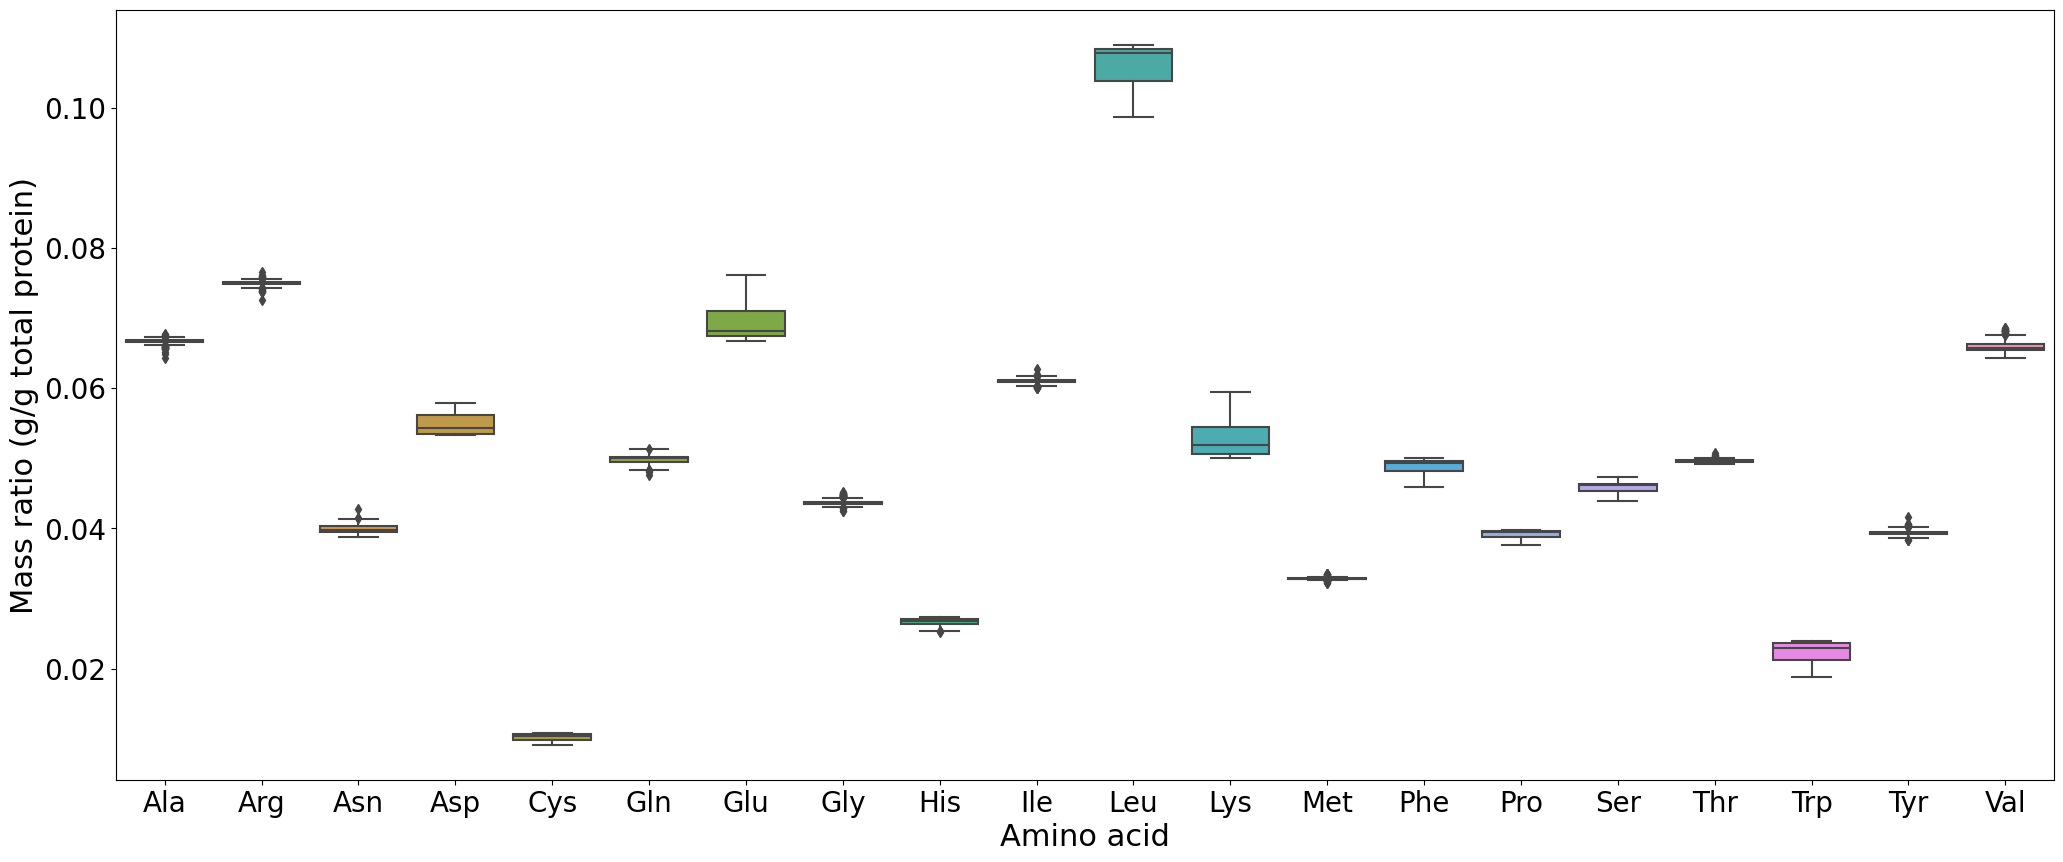

In [103]:
# draw figure
amino_composition_norm_onecell_outfile=result_file + 'amino_composition_g_g_norm_onecell_%s.json'%strain
amino_composition_norm_onecell=json_load(amino_composition_norm_onecell_outfile)
amino_composition_norm_onecell_df=pd.DataFrame()
for key, value in amino_composition_norm_onecell.items():
    for key2 in value.keys():
        amino_composition_norm_onecell_df.loc[key,key2]=value[key2]['total']
        
amino_composition_norm_onecell_df_outfile=result_file + 'amino_composition_proteome_by_condition_%s.csv'%strain
amino_composition_norm_onecell_df.to_csv(amino_composition_norm_onecell_df_outfile, header=True, index=True) 

pngname=result_file + '%s_twenty_amino_condition_boxplot.png'%(strain)
draw_amino_mass_in_total_protein(amino_composition_norm_onecell_df,pngname)

# 能量成本

In [ ]:
strain='MG1655'
protein_expression_mass_norm_outfile='../analysis_result/%s_exp_onecell.json'%strain
protein_expression_mass_norm_data=json_load(protein_expression_mass_norm_outfile) 
protein_expression_mass_norm_df=pd.DataFrame(protein_expression_mass_norm_data).T

seq_amino_composition_file='../analysis_result/seq_amino_composition_%s.csv'%strain
protein_amino_acid_composition=pd.read_csv(seq_amino_composition_file,index_col=0) 

#根据上面两个文件得到，每个氨基酸在不同实验条件下的表达量
#结合吴柯整理的氨基酸合成成本（最后一列）
#获得每个实验条件下，细胞用于合成氨基酸的能力成本——一个小提琴图
#画MG1655，谷棒，枯草和酵母的小提琴图